# Relation Extraction with a BiGRU & CNN Model over RareDis Dataset

In this project, there are developed the necessary steps to deploy a BiGRU & CNN model to extract and classify relations between words from the RareDis dataset.

## 1. Connection with the cloud files

First of all, it is necessary to activate Google Drive in the execution environment (it is also possible to execute `drive.flush_and_unmount()` to unmount the current session, if it is established previously).

In [1]:
#drive.flush_and_unmount() # Optional, only if necessary
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The next step is optional, it is only for checking purpose to test the correct connection with Google Drive and see the current files. It also serves to define a path to work on.

In [2]:
root = '/content/drive/My Drive/Colab Notebooks'
#!ls '/content/drive/My Drive/Colab Notebooks'
print("Current directory: {}".format(root))

Current directory: /content/drive/My Drive/Colab Notebooks


For execution purposes, it is recommendable to ensure that TensorFlow uses GPU. 
In the following some layers will choose different implementations (cuDNN-based or pure-TensorFlow) to maximize the performance. If a GPU is available and all the arguments to the layer meet the requirement of the CuDNN kernel (see each layer separately), the layer will use a fast cuDNN implementation.

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

# If not working try
#!pip install tensorflow==2.1.0

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15282367407265317504
]
Default GPU Device: 


If TensorBoard is to be used, this cell is required. It includes the use of the `tensorboard.notebook` APIs for a bit more control if desired.

In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

from tensorboard import notebook
notebook.list() # View open TensorBoard instances

# Control TensorBoard display. If no port is provided, the most recently launched TensorBoard is used
#notebook.display(port=6006, height=1000)

No known TensorBoard instances running.


## 2. Reading and preprocessing of the dataset

Here, the execution of the actual code is started. At first, all the necessary libraries to deploy the structure are imported for Python.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers, optimizers
from keras.models import Model
from keras.layers import Input, Embedding, concatenate, Conv1D, Bidirectional, GRU, GlobalMaxPooling1D, Dropout, Dense, MaxPooling1D, LSTM
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
import spacy #NLP library for sentence segmentation and tokenization
nlp = spacy.load("en_core_web_sm")
pd.set_option('max_colwidth', None)

The different tokens within the texts can be represented as vectors by word embedding techniques using a random initialization or with a pre-trained model that needs to be preloaded.
Here a variable is defined that allows both approaches (random or using a word embedding model).
If a word embedding model is preferred, it is possible to select the desired model to use.

In [6]:
random_initialization = True # True for using random_initialization

if random_initialization:
    print("Random initialization")

else:
    import time # To track the execution time
    models = {'Google News':'GoogleNews-vectors-negative300.bin.gz', 'GloVe':'glove.840B.300d.zip', 'Wiki-PubMed-PMC':'wikipedia-pubmed-and-PMC-w2v.bin'}
    model_used = models['Google News'] # Change for desired model
    path_w2v = root+'/word_embedding/'+model_used # Change for correct path to the model folder
    print("Charging word embedding model {}...".format(model_used))

    if model_used == 'GoogleNews-vectors-negative300.bin.gz' or model_used == 'wikipedia-pubmed-and-PMC-w2v.bin':
        from gensim.models import KeyedVectors
        start_time = time.time()
        modelw2v = KeyedVectors.load_word2vec_format(path_w2v, binary=True)

    elif model_used == 'glove.840B.300d.zip':
        import zipfile # It allows to manage the file compressed
        start_time = time.time()
        modelw2v = {}
        with zipfile.ZipFile(path_w2v) as zf:
            with zf.open('glove.840B.300d.txt') as f:
                for line in f:
                    values = line.decode('utf-8').split(' ')
                    word = values[0]
                    coefs = np.asarray([float(val) for val in values[1:]])
                    modelw2v[word] = coefs
            zf.close()

  # Some metrics
    execution_time = time.time() - start_time
    print("Elapsed Time:\n\t{:.2f} seconds\n\t{:.2f} min".format(execution_time, execution_time/60))
    print("Model loaded")

Random initialization


After this, the RareDis dataset is readed into a Pandas DataFrame using some data manipulation techniques. For this task, it is necessary to keep the "Sentences" and "Labels" as columns of the resulting dataset.

In [7]:
# Definition of Train & Test Paths
path_train = root + '/relation_extraction/data/gold_nlp4rare_corpus/train.csv'
path_dev = root + '/relation_extraction/data/gold_nlp4rare_corpus/dev.csv'
path_test = root + '/relation_extraction/data/gold_nlp4rare_corpus/test.csv'

# Read of all the datasets
RareDis_df_train = pd.read_csv(path_train)
RareDis_df_train.drop(columns=['Unnamed: 0'], inplace=True)

RareDis_df_dev = pd.read_csv(path_dev)
RareDis_df_dev.drop(columns=['Unnamed: 0'], inplace=True)

RareDis_df_test = pd.read_csv(path_test)
RareDis_df_test.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
RareDis_df_dev

,Sentence,Relation,e1,e2
0,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,Is_a,Cat eye syndrome,chromosomal disorder
1,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,Is_acron,CES,Cat eye syndrome
2,Additional chromosomal disorders may have features similar to those associated with Chromosome 14 Ring.,Is_a,chromosomal disorders,chromosomal disorder
3,"Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.",Produces,Chromosome 9 Ring,growth retardation
4,"Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.",Produces,Chromosome 9 Ring,heart defects
...,...,...,...,...
254,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",Produces,nephrotic syndrome,kidney disease
255,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",Produces,nephrotic syndrome,proteinuria
256,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",Produces,nephrotic syndrome,hematuria
257,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",Produces,nephrotic syndrome,nephrotic syndrome


It is possible to check a distribution of the actual lengths for the sentences of the dataset to infer the desired value of MAX_LENGTH.

Maximum sentence length for train data is 86
Maximum sentence length for dev data is 71
Maximum sentence length for test data is 84


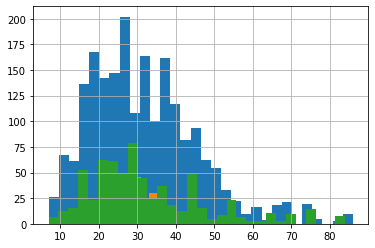

In [9]:
# Train dataset
seq_len_train = [len(nlp(sentence)) for sentence in RareDis_df_train["Sentence"]]
pd.Series(seq_len_train).hist(bins = 30)
print('Maximum sentence length for train data is {}'.format(max(seq_len_train)))

# Dev dataset
seq_len_dev = [len(nlp(sentence)) for sentence in RareDis_df_dev["Sentence"]]
pd.Series(seq_len_dev).hist(bins = 30)
print('Maximum sentence length for dev data is {}'.format(max(seq_len_dev)))

# Test dataset
seq_len_test = [len(nlp(sentence)) for sentence in RareDis_df_test["Sentence"]]
pd.Series(seq_len_test).hist(bins = 30)
print('Maximum sentence length for test data is {}'.format(max(seq_len_test)))

In [10]:
# Define maximum desired length for the sentences
MAX_LENGTH = 90

For this model it will be taken into account both the relatives position of the 2 entities that appears in each of the sentences of the dataset. The relative positions will be stored as new columns in the DataFrame. The following cell serves as an example of the necessary prosecution to perform this operation.

In [11]:
selected = 4

print(RareDis_df_dev.iloc[selected]["Sentence"])

span_sentence = nlp(RareDis_df_dev.iloc[selected]["Sentence"])
span_e1 = nlp(RareDis_df_dev.iloc[selected]["e1"])
span_e2 = nlp(RareDis_df_dev.iloc[selected]["e2"])
print('Sentence lenght (in tokens): ', len(span_sentence))
print('e1: ', RareDis_df_dev.iloc[selected]["e1"], '|| e1 lenght (in tokens): ', len(span_e1))
print('e2: ', RareDis_df_dev.iloc[selected]["e2"], '|| e2 lenght (in tokens): ', len(span_e2))

e1_position = np.zeros(MAX_LENGTH)
e2_position = np.zeros(MAX_LENGTH)

e1_min_pos = len(span_sentence)
e1_max_pos = 0
e2_min_pos = len(span_sentence)
e2_max_pos = 0

for token_e1 in span_e1:
    for token_s in span_sentence:
        # print((token_s.text, token_s.i))
        if token_e1.text == token_s.text:
            e1_min_pos = min(e1_min_pos, token_s.i)
            e1_max_pos = max(e1_max_pos, token_s.i)
            break

for token_e2 in span_e2:
    for token_s in span_sentence:
        # print((token_s.text, token_s.i))
        if token_e2.text == token_s.text:
            e2_min_pos = min(e2_min_pos, token_s.i)
            e2_max_pos = max(e2_max_pos, token_s.i)
            break

print('e1 min pos in sentence: ', e1_min_pos)
print('e1 max pos in sentence: ', e1_max_pos)
print('e2 min pos in sentence: ', e2_min_pos)
print('e2 max pos in sentence: ', e2_max_pos)

e2_position[:e2_min_pos] = [(i-e2_min_pos)*(-1)  for i in range(e2_min_pos)]
e2_position[e2_max_pos:] = [i  for i in range(len(e2_position)-e2_max_pos)]
e1_position[:e1_min_pos] = [(i-e1_min_pos)*(-1)  for i in range(e1_min_pos)]
e1_position[e1_max_pos:] = [i  for i in range(len(e1_position)-e1_max_pos)]
print('vector for e1: ', e1_position)
print('vector for e2: ', e2_position)

Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.
Sentence lenght (in tokens):  29
e1:  Chromosome 9 Ring || e1 lenght (in tokens):  3
e2:  heart defects || e2 lenght (in tokens):  2
e1 min pos in sentence:  0
e1 max pos in sentence:  2
e2 min pos in sentence:  19
e2 max pos in sentence:  20
vector for e1:  [ 0.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.
 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.
 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.
 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69.
 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87.]
vector for e2:  [19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.
  1.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.
 16. 17. 18. 19. 20. 21. 22. 23

Now we define the function to apply to each row of the dataset and perform the operation to all the datasets.

In [12]:
def getRelativePosition(row):
    span_sentence = nlp(row["Sentence"])
    span_e1 = nlp(row["e1"])
    span_e2 = nlp(row["e2"])
    e1_min_pos = len(span_sentence)
    e1_max_pos = 0
    e2_min_pos = len(span_sentence)
    e2_max_pos = 0
    for token_e1 in span_e1:
        for token_s in span_sentence:
            if token_e1.text == token_s.text:
                e1_min_pos = min(e1_min_pos, token_s.i)
                e1_max_pos = max(e1_max_pos, token_s.i)
                break
    for token_e2 in span_e2:
        for token_s in span_sentence:
            if token_e2.text == token_s.text:
                e2_min_pos = min(e2_min_pos, token_s.i)
                e2_max_pos = max(e2_max_pos, token_s.i)
                break
    e1_position = np.zeros(MAX_LENGTH)
    e2_position = np.zeros(MAX_LENGTH)
    e2_position[:e2_min_pos] = [(i-e2_min_pos)*(-1)  for i in range(e2_min_pos)]
    e2_position[e2_max_pos:] = [i  for i in range(len(e2_position)-e2_max_pos)]
    e1_position[:e1_min_pos] = [(i-e1_min_pos)*(-1)  for i in range(e1_min_pos)]
    e1_position[e1_max_pos:] = [i  for i in range(len(e1_position)-e1_max_pos)]
    
    return e1_position, e2_position


test_1, test_2 = getRelativePosition(RareDis_df_dev.iloc[selected])
assert np.array_equal(test_1, e1_position) 
assert np.array_equal(test_2, e2_position)
print("Function ok")

Function ok


In [13]:
RareDis_df_train[['e1_pos', 'e2_pos']] = RareDis_df_train.apply(getRelativePosition, axis=1, result_type="expand")
RareDis_df_dev[['e1_pos', 'e2_pos']] = RareDis_df_dev.apply(getRelativePosition, axis=1, result_type="expand")
RareDis_df_test[['e1_pos', 'e2_pos']] = RareDis_df_test.apply(getRelativePosition, axis=1, result_type="expand")

In [14]:
RareDis_df_dev

,Sentence,Relation,e1,e2,e1_pos,e2_pos
0,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,Is_a,Cat eye syndrome,chromosomal disorder,"[0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0]","[9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0]"
1,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,Is_acron,CES,Cat eye syndrome,"[4.0, 3.0, 2.0, 1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0]","[0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0]"
2,Additional chromosomal disorders may have features similar to those associated with Chromosome 14 Ring.,Is_a,chromosomal disorders,chromosomal disorder,"[1.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0]","[1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0]"
3,"Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.",Produces,Chromosome 9 Ring,growth retardation,"[0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 2

Mapping the labels per integers is the first step to apply one hot encoding afterwards. For this step, we group the categories into the different possible relations.

In [15]:
labels_dict = {'Produces': 0,
               'Increases_risk_of': 1,
               'Is_a': 2,
               'Is_acron': 3,
               'Is_synon': 4,
               }
RareDis_df_train["Relation"] = RareDis_df_train["Relation"].map(labels_dict)
RareDis_df_dev["Relation"] = RareDis_df_dev["Relation"].map(labels_dict)
RareDis_df_test["Relation"] = RareDis_df_test["Relation"].map(labels_dict)

In [16]:
RareDis_df_dev

,Sentence,Relation,e1,e2,e1_pos,e2_pos
0,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,2,Cat eye syndrome,chromosomal disorder,"[0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0]","[9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0]"
1,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,3,CES,Cat eye syndrome,"[4.0, 3.0, 2.0, 1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0]","[0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0]"
2,Additional chromosomal disorders may have features similar to those associated with Chromosome 14 Ring.,2,chromosomal disorders,chromosomal disorder,"[1.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0]","[1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0]"
3,"Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.",0,Chromosome 9 Ring,growth retardation,"[0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.

Afer this, the current labels had to be encoded to one-hot formatting. This is the correct way to present the inputs to the neural network.

In [17]:
y_train = to_categorical(RareDis_df_train["Relation"], num_classes=len(RareDis_df_train["Relation"].unique()))
y_dev = to_categorical(RareDis_df_dev["Relation"], num_classes=len(RareDis_df_dev["Relation"].unique()))
y_test = to_categorical(RareDis_df_test["Relation"], num_classes=len(RareDis_df_test["Relation"].unique()))
print('y_train shape is {}'.format(y_train.shape))
print('y_dev shape is {}'.format(y_dev.shape))
print('y_test shape is {}'.format(y_test.shape))

y_train shape is (2052, 5)
y_dev shape is (259, 5)
y_test shape is (657, 5)


It is possible now to transform the sentences into word indices. Each word has a unique index in the vocabulary constructed from the trained set. The lists are then padded with zeros until a maximum length to ensure that all sentences have the same shape.
To build the word index with the tokenizer, it is possible to use:
- Only the training set of sentences.
- The training and validation sets.

Once selected the desired choice, it is time to select the behaviour with the unknown words:
- Ignore unknown words: default Tokenizer class behaviour.
- Reserve a token for unknown words: `oov_token=True` statement for Tokenizer.
- Have a group of rare words in training data replaced with the reserved token too, so the model has a notion of how to deal with unknown words.

In [18]:
MAX_FEATURES = 150000 # maximum vocabulary size desired

# Full vocabulary from dataset
full_RareDis_df = pd.concat([RareDis_df_train["Sentence"], RareDis_df_dev["Sentence"]], ignore_index=True).copy()
words = full_RareDis_df.values

# Initialization
tokenizer = Tokenizer(num_words=MAX_FEATURES, filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True, oov_token='UNK')

# Fitting the internal dictionary (creation)
tokenizer.fit_on_texts(words)
word_index = tokenizer.word_index
print('Found {} unique tokens in trained data.'.format(len(word_index)))

# Transforming the datasets according to the created dictionary
sequences_train = tokenizer.texts_to_sequences(RareDis_df_train["Sentence"].values)
sequences_dev = tokenizer.texts_to_sequences(RareDis_df_dev["Sentence"].values)
sequences_test = tokenizer.texts_to_sequences(RareDis_df_test["Sentence"].values)

# Padding
X_train = pad_sequences(sequences_train, maxlen=MAX_LENGTH)
X_dev = pad_sequences(sequences_dev, maxlen=MAX_LENGTH)
X_test = pad_sequences(sequences_test, maxlen=MAX_LENGTH)

# Output information
print('X_train shape is {}'.format(X_train.shape))
print('X_dev shape is {}'.format(X_dev.shape))
print('X_test shape is {}'.format(X_test.shape))

Found 4196 unique tokens in trained data.
X_train shape is (2052, 90)
X_dev shape is (259, 90)
X_test shape is (657, 90)


In the same way that the sentences are tokenized in the resulting matrix `X_train` for training data, it will be necessary to adapt the matrix for each of the relative positions correctly to feed the neural network afterwards. These matrices will be called (`X_train_pos1`,`X_train_pos2`), (`X_dev_pos1`,`X_dev_pos2`) and (`X_test_pos1`,`X_test_pos2`).

In [19]:
# Processing for train data
X_train_pos1 = [value for value in RareDis_df_train["e1_pos"].values]
X_train_pos1 = np.array(X_train_pos1, dtype='float32')
X_train_pos2 = [value for value in RareDis_df_train["e2_pos"].values]
X_train_pos2 = np.array(X_train_pos2, dtype='float32')

# Processing for dev data
X_dev_pos1 = [value for value in RareDis_df_dev["e1_pos"].values]
X_dev_pos1 = np.array(X_dev_pos1, dtype='float32')
X_dev_pos2 = [value for value in RareDis_df_dev["e2_pos"].values]
X_dev_pos2 = np.array(X_dev_pos2, dtype='float32')

# Processing for test data
X_test_pos1 = [value for value in RareDis_df_test["e1_pos"].values]
X_test_pos1 = np.array(X_test_pos1, dtype='float32')
X_test_pos2 = [value for value in RareDis_df_test["e2_pos"].values]
X_test_pos2 = np.array(X_test_pos2, dtype='float32')

# Outputs
print('X_train_pos1 shape is {}'.format(X_train_pos1.shape))
print('X_train_pos2 shape is {}'.format(X_train_pos2.shape))
print('X_dev_pos1 shape is {}'.format(X_dev_pos1.shape))
print('X_dev_pos2 shape is {}'.format(X_dev_pos2.shape))
print('X_test_pos1 shape is {}'.format(X_test_pos1.shape))
print('X_test_pos2 shape is {}'.format(X_test_pos2.shape))

X_train_pos1 shape is (2052, 90)
X_train_pos2 shape is (2052, 90)
X_dev_pos1 shape is (259, 90)
X_dev_pos2 shape is (259, 90)
X_test_pos1 shape is (657, 90)
X_test_pos2 shape is (657, 90)


This next step is optional and only needed if it is necessary to create the word embedding matrix (i.e., not using random initialization).
Here we create a matrix to store the word vectors of the words from the vocabulary `word_index` defined previously.
It provides a function in order to create it along with its creation.

In [20]:
def getEmbeddingMatrix(word_index, MAX_FEATURES, model, dimensionality):
    """This functions creates a matrix where each file is a word embedding vector.
      Inputs:
          word_index = refers to the tokenized word index from our dataset
          MAX_FEATURES = refers to the maximum vocabulary size desired
          model = refers to the word embedding dictionary model used
          dimensionality = refers to the size of the one-dimensional vectors in the word embedding model used
    """
    # first create a matrix of zeros, this is our embedding matrix
    num_words = min(MAX_FEATURES, len(word_index)) + 1 # +1 because of the padding token
    print("Nr of words [(maximum vocabulary size | word_index) +1 padded]: {}".format(num_words))
    embedding_matrix = np.zeros((num_words, dimensionality), dtype=np.float32)

    # for each word in our word_index lets get the equivalent model vector
    for word, i in word_index.items():
        if i > MAX_FEATURES:
            continue
        if word in model:
            embedding_matrix[i] = model[word]
        # If word doesn't exist in model, let the vector of zeros

    #print (count," ",num_words)
    print("Shape of the embedding matrix: {}".format(embedding_matrix.shape))
    print("Nr of words inside the model: {}".format(int((np.count_nonzero(embedding_matrix, axis=None))/dimensionality)))
    return embedding_matrix, num_words


if random_initialization:
    dim_embedding = 300
    print("No Embedding matrix needed")
else:
    dim_embedding = 300 #by default, 300 dimension for the vectors representing the tokens
    if model_used == 'wikipedia-pubmed-and-PMC-w2v.bin':
        dim_embedding = 200
    embedding_matrix, num_words = getEmbeddingMatrix(word_index, MAX_FEATURES, modelw2v, dim_embedding)
    print("Embedding matrix for {} model was successfully created".format(model_used))

No Embedding matrix needed


## 3. Building the Bi-GRU & CNN Model

A simple model with on convolutional layer followed by 3 dense layers interspersed by 3 dropout layers. They are both preceded by an Embedding layer, which "learns" a vector representations of the categorical data introduced.
The functional API of Keras is used to deploy the model.

Embedding layer with random initialization
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 90, 300)      45000000    input_1[0][0]                    
___________________________________________________

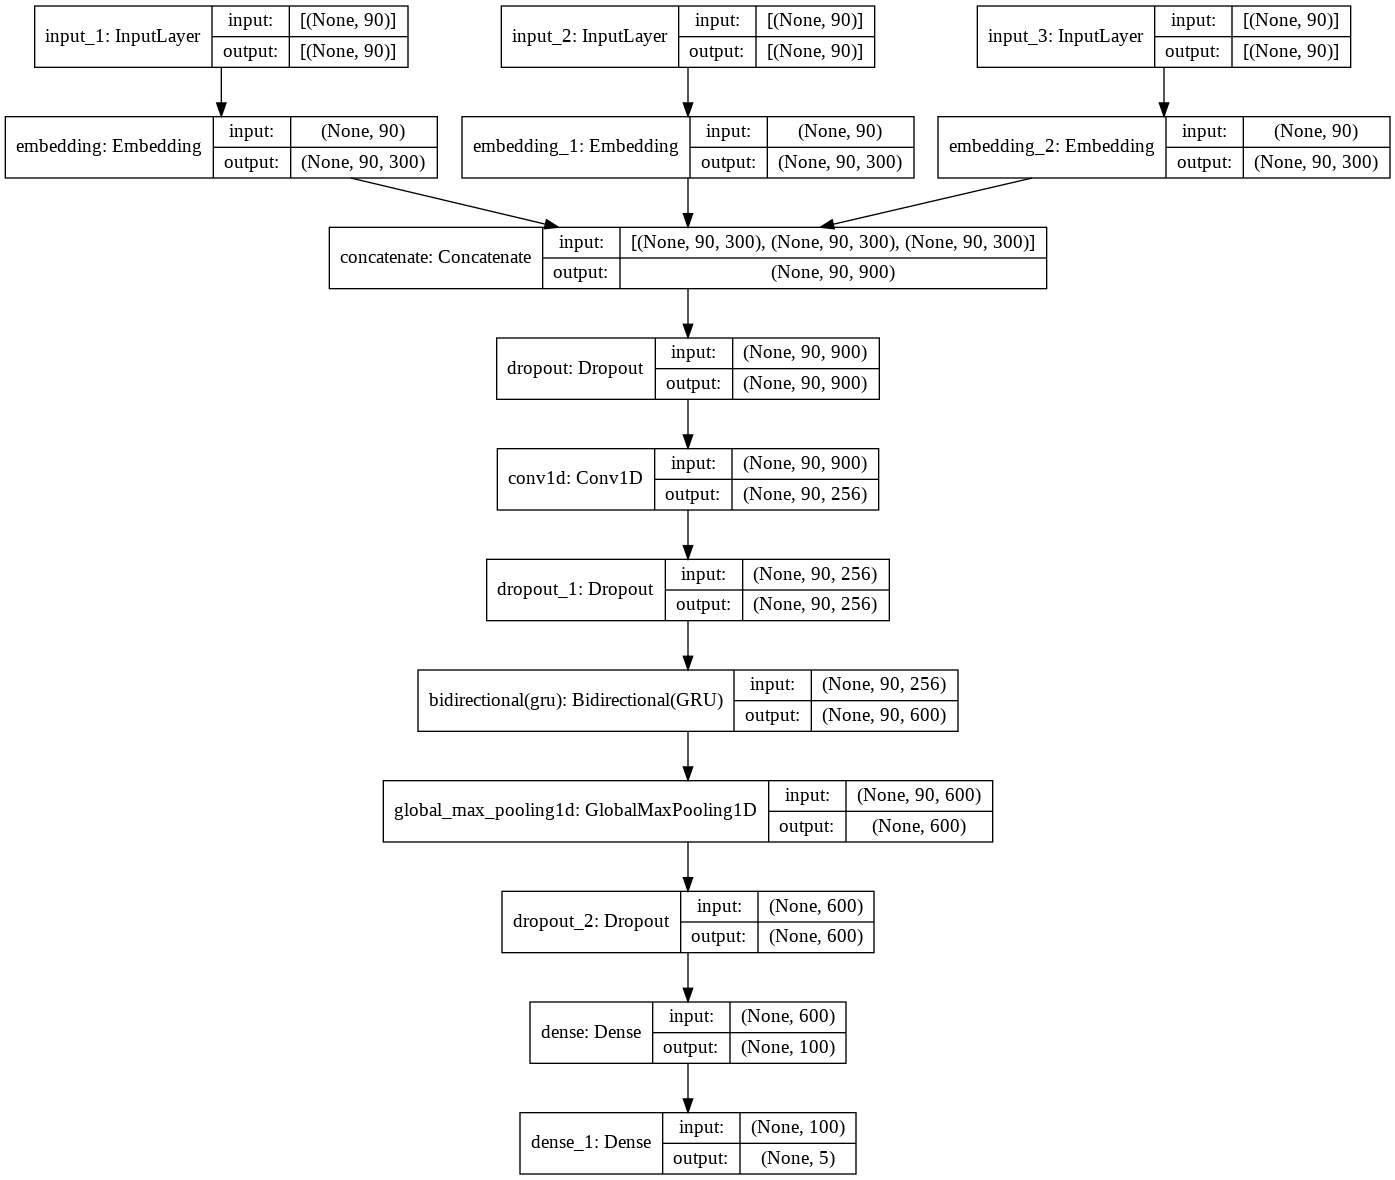

In [21]:
# Network Hyperparameters
EMBEDDING_SIZE = dim_embedding
EPOCHS = 25
BATCH_SIZE = 32
FILTER_NUMBER = 256 # dimensionality of the output space for the convolutional layer
KERNEL_SIZE = 3 # size of the kernel for the convolutional layer
EMBEDDING_REGULARIZER = regularizers.l2(1e-5) # Regularizer for embedding layer
KERNEL_REGULARIZER = regularizers.l2(1e-5) # Regularizer for convolutional layer and dense layer
RECURRENT_REGULARIZER = regularizers.l2(1e-5) # Regularizer for recurrent layer
UNITS_GRU = 300 # Units for GRU layer
UNITS_DENSE = 100 # Units for dense layer
#OPTIMIZER = keras.optimizers.Adam(learning_rate=1e-4) # Optimizer for the model
OPTIMIZER = keras.optimizers.Adadelta(learning_rate=1.0, decay=0.0)

# To build this model using the functional API, start by creating the input node:
input_seq = Input(shape=(X_train.shape[1],))
input_seq_pos1 = Input(shape=(X_train_pos1.shape[1],))
input_seq_pos2 = Input(shape=(X_train_pos2.shape[1],))

# Node Embedding Layer
if random_initialization:
  embed_seq = Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_SIZE, embeddings_regularizer=EMBEDDING_REGULARIZER)(input_seq) # Embedding for the matrix of sentences
  embed_seq_pos1 = Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_SIZE, input_length=MAX_LENGTH, embeddings_regularizer=EMBEDDING_REGULARIZER)(input_seq_pos1) # Embedding for the matrix of relative positions e1
  embed_seq_pos2 = Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_SIZE, input_length=MAX_LENGTH, embeddings_regularizer=EMBEDDING_REGULARIZER)(input_seq_pos2) # Embedding for the matrix of relative positions e2
  print("Embedding layer with random initialization")
else:
  embed_seq = Embedding(input_dim=num_words, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], embeddings_regularizer=EMBEDDING_REGULARIZER)(input_seq) # Embedding for the matrix of sentences
  embed_seq_pos1 = Embedding(input_dim=num_words, output_dim=EMBEDDING_SIZE, input_length=MAX_LENGTH, embeddings_regularizer=EMBEDDING_REGULARIZER)(input_seq_pos1) # Embedding for the matrix of relative positions e1
  embed_seq_pos2 = Embedding(input_dim=num_words, output_dim=EMBEDDING_SIZE, input_length=MAX_LENGTH, embeddings_regularizer=EMBEDDING_REGULARIZER)(input_seq_pos2) # Embedding for the matrix of relative positions e2
  print("Embedding layer with {} model loaded".format(model_used))

# Concatenate
output = concatenate([embed_seq, embed_seq_pos1, embed_seq_pos2])

# Node Dropout 1
output = Dropout(rate=.7)(output)

# Node Convolutional Layer
output = Conv1D(filters=FILTER_NUMBER, kernel_size=KERNEL_SIZE, padding='same', activation='tanh', strides=1, kernel_regularizer=KERNEL_REGULARIZER)(output)

# Node Dropout 2
output = Dropout(rate=.5)(output)

# Node Bidirectional with GRU layer
output = Bidirectional(GRU(units=UNITS_GRU, return_sequences=True, activation='tanh', recurrent_regularizer=RECURRENT_REGULARIZER), merge_mode="concat")(output)

# Node Max Pooling
output = GlobalMaxPooling1D()(output)

# Node Dropout 3
output = Dropout(rate=.3)(output)

# Node Dense Layer
output = Dense(units=UNITS_DENSE, activation='relu', kernel_regularizer=KERNEL_REGULARIZER)(output)

# Node Dense Layer Final
output = Dense(units=y_train.shape[1], activation='softmax', kernel_regularizer=KERNEL_REGULARIZER)(output)

# Create a Model by specifying its inputs and outputs in the graph of layers:
model = Model(inputs=[input_seq, input_seq_pos1, input_seq_pos2], outputs=[output])
print(model.summary())
plot_model(model, show_shapes=True)

Training the model is the remaining task. In addition, several optional callbacks are defined to manipulate the behaviour the model if desired:
- Early stopping configuration
- Save of the model (best or not)
- Use of TensorBoard

In [22]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=["accuracy"])

# Definition of the callbacks
es = True # EarlyStopping use
mc = False # ModelCheckpoint use
tb = False # TensorBoard use

my_callbacks = []
if es:
  my_callbacks.append(EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True))
  print('Used EarlyStopping')
if mc:
  checkpoint_filepath = root+'/relation_extraction/checkpoints/'+'model.{epoch:02d}-{val_loss:.2f}.h5'
  my_callbacks.append(ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True))
  print('Used ModelCheckpoint')
if tb:
  import datetime, os
  logdir = os.path.join(root+'/relation_extraction/logs/fit/', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  my_callbacks.append(TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_images=False))
  %tensorboard --logdir /content/drive/MyDrive/Colab\ Notebooks/relation_extraction/logs # to monitor the training in progress
  print('Used TensorBoard')

# Train the model
from numpy.random import seed
seed(42)
tf.random.set_seed(42)
history = model.fit([X_train, X_train_pos1, X_train_pos2], y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=([X_dev, X_dev_pos1, X_dev_pos2], y_dev), callbacks=my_callbacks)

Used EarlyStopping
Epoch 1/25
65/65 [==============================] - 175s 3s/step - loss: 2.2052 - accuracy: 0.6033 - val_loss: 2.2886 - val_accuracy: 0.5560
Epoch 2/25
65/65 [==============================] - 165s 3s/step - loss: 2.0250 - accuracy: 0.6598 - val_loss: 2.3516 - val_accuracy: 0.6332
Epoch 3/25
65/65 [==============================] - 164s 3s/step - loss: 1.8912 - accuracy: 0.7203 - val_loss: 2.1252 - val_accuracy: 0.6332
Epoch 4/25
65/65 [==============================] - 167s 3s/step - loss: 1.8042 - accuracy: 0.7627 - val_loss: 1.8900 - val_accuracy: 0.7452
Epoch 5/25
65/65 [==============================] - 164s 3s/step - loss: 1.7334 - accuracy: 0.7831 - val_loss: 2.0403 - val_accuracy: 0.6525
Epoch 6/25
65/65 [==============================] - 164s 3s/step - loss: 1.6892 - accuracy: 0.7929 - val_loss: 1.8461 - val_accuracy: 0.7568
Epoch 7/25
65/65 [==============================] - 164s 3s/step - loss: 1.6312 - accuracy: 0.8124 - val_loss: 1.8795 - val_accuracy: 0

Optional: Visualize the resulting training of the network.

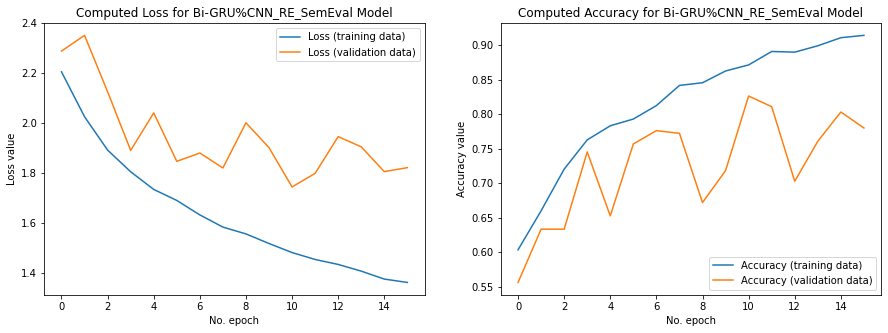

In [23]:
# Define figure
fig_results = plt.figure(figsize=(15, 5))
ax_loss = fig_results.add_subplot(1, 2, 1)
ax_accuracy = fig_results.add_subplot(1, 2, 2)

# Plot history: Loss
ax_loss.plot(history.history['loss'], label='Loss (training data)')
ax_loss.plot(history.history['val_loss'], label='Loss (validation data)')
ax_loss.set_title('Computed Loss for Bi-GRU%CNN_RE_SemEval Model')
ax_loss.set_ylabel('Loss value')
ax_loss.set_xlabel('No. epoch')
ax_loss.legend(loc="upper right")

# Plot history: Accuracy
ax_accuracy.plot(history.history['accuracy'], label='Accuracy (training data)')
ax_accuracy.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
ax_accuracy.set_title('Computed Accuracy for Bi-GRU%CNN_RE_SemEval Model')
ax_accuracy.set_ylabel('Accuracy value')
ax_accuracy.set_xlabel('No. epoch')
ax_accuracy.legend(loc="lower right")
plt.show()

## 4. Evaluation and metrics

For the evaluation of the model, accuracy alone doesn’t truly reflect the performance of our model, so we use the predict function, which outputs the probability for each class. The index of the maximum corresponds to the actual prediction.

In [24]:
# Scores of the accuracy of trained network in validation
validation_scores = model.evaluate([X_dev, X_dev_pos1, X_dev_pos2], y_dev, verbose=2)
print("Validation loss:", validation_scores[0])
print("Validation accuracy:", validation_scores[1])

# Scores of the accuracy of trained network in test
test_scores = model.evaluate([X_test, X_test_pos1, X_test_pos2], y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

# Predictions of the trained network in validation
prediction_probabilities_validation = model.predict([X_dev, X_dev_pos1, X_dev_pos2]) 
predictions_validation = [np.argmax(pred) for pred in prediction_probabilities_validation] # predictions represented as integer category
y_true_validation = [np.argmax(value) for value in y_dev] # actual values represented as integer category

# Predictions of the trained network in test
prediction_probabilities_test = model.predict([X_test, X_test_pos1, X_test_pos2]) 
predictions_test = [np.argmax(pred) for pred in prediction_probabilities_test] # predictions represented as integer category
y_true_test = [np.argmax(value) for value in y_test] # actual values represented as integer category

9/9 - 4s - loss: 1.7433 - accuracy: 0.8263
Validation loss: 1.7432806491851807
Validation accuracy: 0.8262548446655273
21/21 - 9s - loss: 1.8226 - accuracy: 0.7656
Test loss: 1.8226186037063599
Test accuracy: 0.7656012177467346


The confusion matrix and the classification report are then displayed. They presents the precision, recall and f1 score for each class.

1.   Confusion Matrix representation

Each line corresponds to the true label and each column to the prediction. The scale bar is expressed as percentages.

Confusion matrix in validation:
[[131   1   9   1   1]
 [  7   4   0   0   0]
 [ 15   0  51   1   1]
 [  2   0   1  22   0]
 [  3   1   0   2   6]]
Confusion matrix in test:
[[353  11  34   6   4]
 [ 15   5   4   3   2]
 [ 46   4  96   4   4]
 [  4   1   4  40   2]
 [  3   0   3   0   9]]


Text(0.5, 1.0, 'Confusion Matrix for Test')

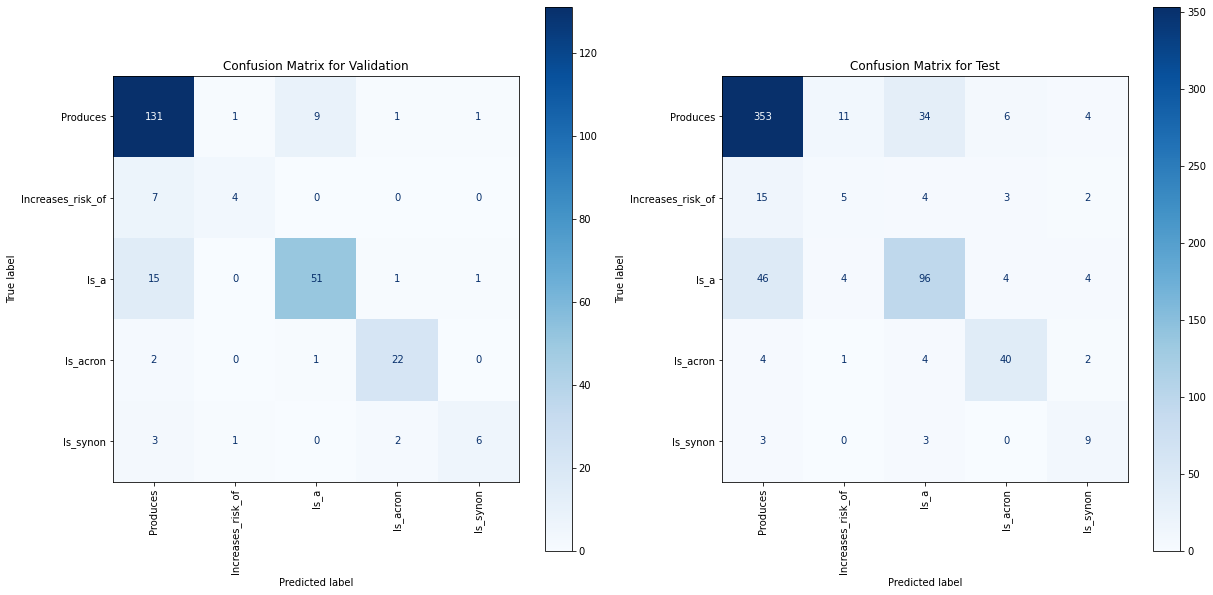

In [25]:
relations = ['Produces',
            'Increases_risk_of',
            'Is_a',
            'Is_acron',
            'Is_synon',        
]

# Calculating Confusion Matrix in validation
cm_val = confusion_matrix(y_true_validation, predictions_validation)
print('Confusion matrix in validation:', cm_val, sep='\n')

# Calculating Confusion Matrix in test
cm_test = confusion_matrix(y_true_test, predictions_test)
print('Confusion matrix in test:', cm_test, sep='\n')

# Visualizing both Confusion Matrix
fig_cm = plt.figure(figsize=(20,10))
ax1_cm = fig_cm.add_subplot(1,2,1)
ax2_cm = fig_cm.add_subplot(1,2,2)
ConfusionMatrixDisplay(cm_val, display_labels=relations).plot(cmap='Blues', xticks_rotation='vertical', values_format='', ax=ax1_cm)
ConfusionMatrixDisplay(cm_test, display_labels=relations).plot(cmap='Blues', xticks_rotation='vertical', values_format='', ax=ax2_cm)
ax1_cm.set_title('Confusion Matrix for Validation')
ax2_cm.set_title('Confusion Matrix for Test')

2.   Classification report representation

Builds a text report showing the main classification metrics.



In [26]:
print('Classification report in validation:', classification_report(y_true_validation, predictions_validation, digits=4), sep='\n')
print('Classification report in test:', classification_report(y_true_test, predictions_test, digits=4), sep='\n')

Classification report in validation:
              precision    recall  f1-score   support

           0     0.8291    0.9161    0.8704       143
           1     0.6667    0.3636    0.4706        11
           2     0.8361    0.7500    0.7907        68
           3     0.8462    0.8800    0.8627        25
           4     0.7500    0.5000    0.6000        12

    accuracy                         0.8263       259
   macro avg     0.7856    0.6819    0.7189       259
weighted avg     0.8220    0.8263    0.8192       259

Classification report in test:
              precision    recall  f1-score   support

           0     0.8385    0.8652    0.8516       408
           1     0.2381    0.1724    0.2000        29
           2     0.6809    0.6234    0.6508       154
           3     0.7547    0.7843    0.7692        51
           4     0.4286    0.6000    0.5000        15

    accuracy                         0.7656       657
   macro avg     0.5881    0.6091    0.5943       657
weighted 